Cześć, przesyłam projekt w formie odbiegającej od wytycznych, ale zbyt późno zauważyłam wiadomość o rekrutacji i zabrakło mi czasu. Dopiero zaczynam przygodę z ML, w wakacje przerobiłam pierwszą część "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" pod koniec września byłam na praktykach w evorain. Mój poziom to bardziej samodzielnie napisany perceptron albo prosta sieć, która przewiduje wysokość cen (z użyciem tensorflow). To jest mój pierwszy model w którym mam do czynienia z obrazami, dlatego opierałam się mocno na tutorialach. Jeśli nie jest to dla Was problem, że dopiero zaczynam i potrzebuję się jeszcze wiele doczuć to chętnie dołączę w Wasze szeregi ;) 
Aktualnie jestem na 3 semestrze matematyki stosowanej, skończyłam pierwszy stopień z architektury. 

In [28]:
import tensorflow as tf
from fastai.vision.all import*
import bs4
import os
import shutil
import numpy as np
import pandas as pd 
import pathlib
import matplotlib.pyplot as plt
from urllib.request import urlopen

from PIL import Image

import IPython
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
"""file paths"""

path ="C:/Users/kinga/Desktop/zadanie/RoadSignsPascalVOC/"
path_images = path + os.listdir(path)[1] 
path_annotations = path +  os.listdir(path)[0]
path =Path("C:/Users/kinga/Desktop/zadanie/RoadSignsPascalVOC")
content=[]

path_images = Path(path_images)
Path.BASE_PATH = path_images


In [ ]:
"""To split the photos for no speed limit class and speed limit class"""

from bs4 import BeautifulSoup

for i in path_images.ls()[2:]:
    xml_name = re.findall(r'(.+)\.png$', i.name)[0]
    
    fd = open("C:/Users/kinga/Desktop/zadanie/RoadSignsPascalVOC/annotations/" + xml_name + ".xml", 'r')
    xml_file = fd.read()
    soup = BeautifulSoup(xml_file, 'lxml')
    fd.close()
    tag = soup.findAll('name')[0]
    current_file_path = "C:/Users/kinga/Desktop/zadanie/RoadSignsPascalVOC/images/" + xml_name + ".png"
    limit_file_path = "C:/Users/kinga/Desktop/zadanie/RoadSignsPascalVOC/images/limit_sign/" + xml_name + ".png"
    no_limit_file_path = "C:/Users/kinga/Desktop/zadanie/RoadSignsPascalVOC/images/no_limit_sign/" + xml_name + ".png"
    
    if "speedlimit" in tag:
        shutil.move(current_file_path, limit_file_path)
    else:
        shutil.move(current_file_path, no_limit_file_path)

In [3]:
"""Size of the files"""
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_path = Path("C:/Users/kinga/Desktop/zadanie/RoadSignsPascalVOC/images")


Splitage of the data into validation set (20%) and training set (80%)

In [6]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 877 files belonging to 2 classes.
Using 702 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 877 files belonging to 2 classes.
Using 175 files for validation.


In [8]:
"The names of classes"
class_names = train_ds.class_names
print(class_names)

['limit_sign', 'no_limit_sign']


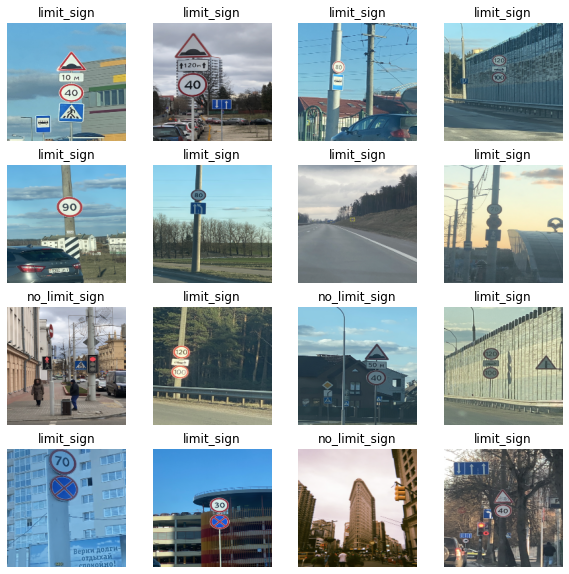

In [11]:
"""Samples from the data set. Image + label"""
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
"""Tensor shape: image_batch:(image amout, shape, shape, color channels RGB); labels_batch(amount of labels) """
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data. Values in range [0,1]

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


Model

In [16]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [19]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
22/22 [==============================] - 13s 525ms/step - loss: 0.7057 - accuracy: 0.6709 - val_loss: 0.4669 - val_accuracy: 0.8114
Epoch 2/20
22/22 [==============================] - 11s 507ms/step - loss: 0.5120 - accuracy: 0.7650 - val_loss: 0.4246 - val_accuracy: 0.8457
Epoch 3/20
22/22 [==============================] - 11s 491ms/step - loss: 0.4671 - accuracy: 0.8091 - val_loss: 0.4981 - val_accuracy: 0.7886
Epoch 4/20
22/22 [==============================] - 11s 483ms/step - loss: 0.4184 - accuracy: 0.8348 - val_loss: 0.3785 - val_accuracy: 0.8457
Epoch 5/20
22/22 [==============================] - 11s 509ms/step - loss: 0.3663 - accuracy: 0.8661 - val_loss: 0.4022 - val_accuracy: 0.8400
Epoch 6/20
22/22 [==============================] - 11s 509ms/step - loss: 0.3451 - accuracy: 0.8632 - val_loss: 0.4580 - val_accuracy: 0.8286
Epoch 7/20
22/22 [==============================] - 11s 520ms/step - loss: 0.2947 - accuracy: 0.8803 - val_loss: 0.4424 - val_accuracy: 0.8229

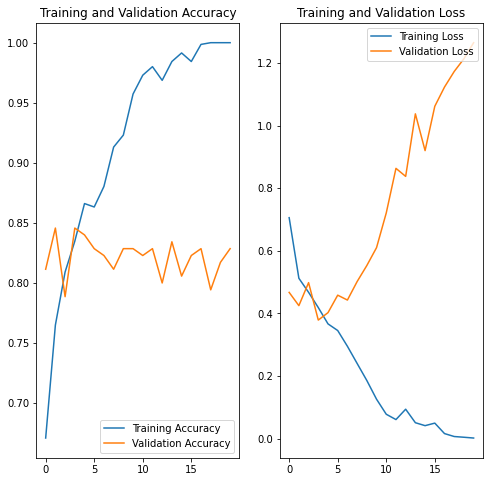

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
test_set = ["https://industrytoday.com/wp-content/uploads/2020/04/pedestrian-crossing-road-signs.jpg", "https://bi.im-g.pl/im/58/18/19/z26316376IBG,Ministerstwo-Infrastruktury-oglosilo-projekty-rozp.jpg", "https://i.iplsc.com/-/0006ZSB4PIEF1T2T-C411.jpg","https://powszechna-wiedza.pl/wp-content/uploads/2018/06/lifestyle-testy-na-prawo-jazdy-znaki-drogowe.jpg","https://i.iplsc.com/-/0006ZSB4PIEF1T2T-C411.jpg", "https://mlyi9tvtxlqg.i.optimole.com/gtOqUmI-NDy2DFQM/w:1024/h:682/q:78/https://unistop.pl/wp-content/uploads/2018/12/znak-50.jpg"]


In [26]:
ans = []
for sign_test_url in test_set:
    

    sign_test_path = tf.keras.utils.get_file('test_sing_nolimit', origin=sign_test_url)

    img = tf.keras.utils.load_img(
        sign_test_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    result = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
    ans.append(result)


    #print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to no_limit_sign with a 100.00 percent confidence.


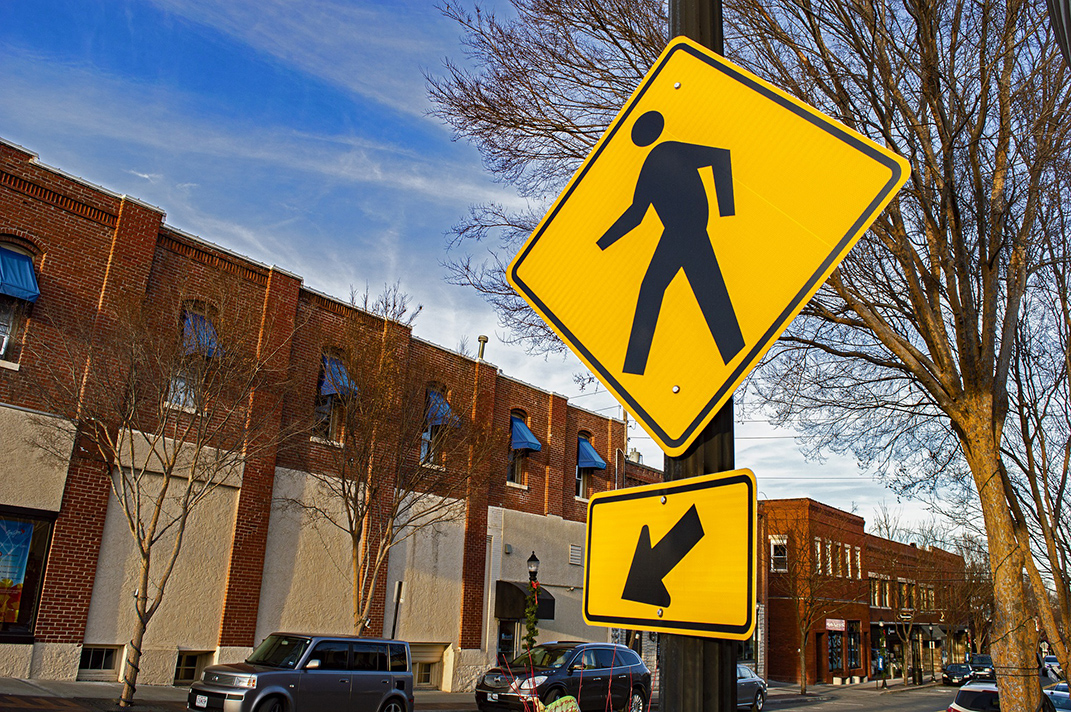

In [31]:
n = random.randint(0,len(test_set))
print(ans[n])
IPython.display.Image(test_set[n], width = 250)